In [149]:
import os, glob, math, argparse
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ----- Casual CNN & Head -------
class CausalCNN(nn.Module):
    def __init__(self, input_size, embed_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=4, dilation=4),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Conv1d(64, embed_size, kernel_size=1)
        )
        
    def forward(self, x):
        return self.cnn(x)
    
class ClassificationHead(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(embed_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        return self.head(x);

In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} (device)")

# load the dataset
inputs_path = os.path.join("./data/cnn_pretrain", "inputs_outfile.npy")
targets_path = os.path.join("./data/cnn_pretrain", "targets_outfile.npy")
X = np.load(inputs_path).astype(np.float32)
y = np.load(targets_path).astype(np.float32)

Using cuda (device)


In [151]:
N = len(X)
split = int(0.9*N)

# create tensors and dataloader
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

train_ds = TensorDataset(X_tensor[:split], y_tensor[:split])
val_ds = TensorDataset(X_tensor[split:], y_tensor[split:])

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2)

# modelaawdasdz
cnn = CausalCNN(X.shape[-1], embed_size=128).to(device)
head = ClassificationHead(128).to(device)
optimizer = torch.optim.Adam(list(cnn.parameters()) + list(head.parameters()), lr=0.006)
criterion = nn.CrossEntropyLoss()

[0.2839561  0.28312683 0.28055835 0.28396237 0.21895811 0.27749637
 0.24048579 0.2421384  0.26253948 0.30223098 0.31391072 0.30622277
 0.25899816 0.23372759 0.25405997 0.21198408 0.26603797 0.23648092
 0.34494072 0.34591654 0.34185305 0.34498322 0.33554122 0.32507235
 0.33875045 0.33676788 0.3394223  0.33645207 0.319321   0.33648607
 0.34076795 0.33663368 0.33192086 0.34062535 0.32026172 0.3426909
 0.2807916  0.28097808 0.27730158 0.2807976  0.21712548 0.2765161
 0.24244475 0.24144532 0.26317474 0.30099514 0.31193653 0.30363077
 0.25873074 0.23700635 0.25510034 0.21722057 0.26680514 0.23886777
 0.3400681  0.34627217 0.33914894 0.34003153 0.33586535 0.3275876
 0.33680898 0.334945   0.3366962  0.33398196 0.3176842  0.3361569
 0.3391903  0.3349598  0.33177158 0.34243307 0.32258305 0.33858457]


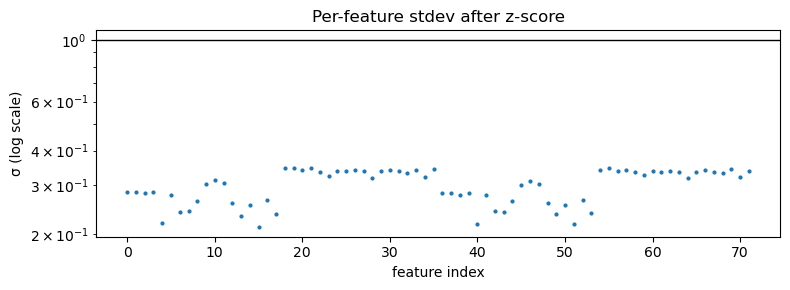

In [152]:
sigmas = X.std(axis=(0, 1))        # shape (F,)
print(sigmas)

plt.figure(figsize=(8,3))
plt.semilogy(sigmas, '.', markersize=4)
plt.axhline(1.0, color='k', lw=1) # ideal target σ
plt.title("Per-feature stdev after z-score")
plt.xlabel("feature index"); plt.ylabel("σ (log scale)")
plt.tight_layout()

In [153]:
# training loop
print("Start training...")
best_val = float("inf")
val_loss = float("inf")
train_hist, val_hist = [], []
wait = 0
for epoch in range(200):
    # -------- train ----------
    cnn.train(); head.train()
    train_loss = 0
    train_preds, train_labels = [], []
    for X, y in tqdm(train_dl, desc=f"epoch {epoch+1}/{200}"):
        X, y = X.to(device), y.squeeze().long().to(device)
        feat_map = cnn.forward(X.permute(0, 2, 1))  # (B, E, T)
        pooled, _ = feat_map.max(dim=2) # (B, E)
        logits = head(pooled)  # (B, 2)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  
        # print("Grad mean:", cnn.cnn[0].weight.grad.abs().mean().item())
        # print("Grad std:", cnn.cnn[0].weight.grad.abs().std().item())
        train_preds.append(torch.argmax(logits, dim=1).cpu().numpy())
        train_labels.append(y.cpu().numpy())
        
    train_acc = balanced_accuracy_score(np.concatenate(train_labels), np.concatenate(train_preds))
    train_loss /= len(train_dl)
    # -------- validation ----------
    val_loss = 0
    val_preds, val_labels = [], []
    cnn.eval(); head.eval()
    with torch.no_grad():
        for X, y in val_dl:
            X, y = X.to(device), y.squeeze(1).long().to(device)
            feat_map = cnn.forward(X.permute(0, 2, 1))  # (B, E, T)
            pooled, _ = feat_map.max(dim=2) # (B, E)
            logits = head(pooled)  # (B, 2)
            val_loss += criterion(logits, y).item()
            
        val_preds.append(torch.argmax(logits, dim=1).cpu().numpy())
        val_labels.append(y.cpu().numpy())
        
    val_acc = balanced_accuracy_score(np.concatenate(val_labels), np.concatenate(val_preds))
    val_loss /= len(val_dl)
    
    train_hist.append(train_loss)
    val_hist.append(val_loss)  
    print(f"train_loss {train_loss:.4f} - train accuracy {train_acc:.4f} \nvalidation_loss {val_loss:4f} - validation accuracy {val_acc:.4f}")

    # ------- early stopping ---------
    if val_loss < best_val: 
        best_val = val_loss
        wait = 0
        torch.save({"cnn": cnn.state_dict(), "head": head.state_dict()}, "cnn_pretrain.pt")
    else:
        wait += 1
        if wait >= 10:
            print(f'Saved CNN weights -> {"cnn_pretrain.pt"}')
            break


Start training...


epoch 1/200: 100%|██████████| 156/156 [00:05<00:00, 27.77it/s]


train_loss 0.6937 - train accuracy 0.5003 
validation_loss 0.693145 - validation accuracy 0.5000


epoch 2/200: 100%|██████████| 156/156 [00:04<00:00, 35.79it/s]


train_loss 0.6931 - train accuracy 0.4992 
validation_loss 0.693159 - validation accuracy 0.5000


epoch 3/200: 100%|██████████| 156/156 [00:04<00:00, 36.97it/s]


train_loss 0.6932 - train accuracy 0.4995 
validation_loss 0.694071 - validation accuracy 0.5000


epoch 4/200: 100%|██████████| 156/156 [00:04<00:00, 35.77it/s]


train_loss 0.6932 - train accuracy 0.4982 
validation_loss 0.693335 - validation accuracy 0.5000


epoch 5/200: 100%|██████████| 156/156 [00:04<00:00, 36.10it/s]


train_loss 0.6932 - train accuracy 0.4982 
validation_loss 0.693139 - validation accuracy 0.5000


epoch 6/200: 100%|██████████| 156/156 [00:04<00:00, 36.57it/s]


KeyboardInterrupt: 

balanced accuracy:  0.5077188591581544
              precision    recall  f1-score   support

           0       0.50      0.69      0.58      2117
           1       0.52      0.32      0.40      2158

    accuracy                           0.51      4275
   macro avg       0.51      0.51      0.49      4275
weighted avg       0.51      0.51      0.49      4275



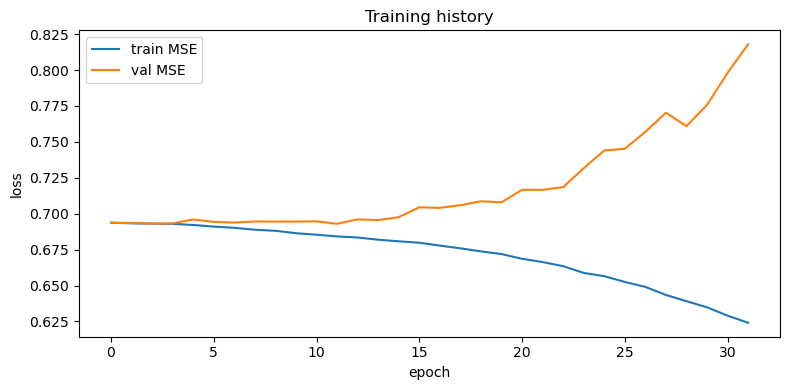

In [141]:
print("validation balanced accuracy: ", balanced_accuracy_score(val_labels, val_preds))
print(classification_report(val_labels, val_preds))

plt.figure(figsize=(8,4))
plt.plot(train_hist, label="train MSE")
plt.plot(val_hist,   label="val MSE")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training history")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
unique_wind = X_tensor.unique()
print(unique_wind)
print(unique_wind.shape)

tensor([-0.1372, -0.1370, -0.1368,  ..., 38.2830, 45.2362, 51.4052])
torch.Size([661753])


In [27]:
X_tensor.shape

torch.Size([44257, 168, 74])